In [1]:
import urllib.request
import string, math, time, collections, pprint
import json
import pandas as pd
import nltk.corpus
import nltk.tokenize
import numpy as np
import keras
import matplotlib.pyplot as plt
import sklearn
import gensim
import os
import nltk, re, pprint
import textblob
import stanfordcorenlp
import seaborn as sns
import functools

from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import brown
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#This takes the json structure from the pushshift api
with urllib.request.urlopen('https://api.pushshift.io/reddit/search/submission/?subreddit=BirthControl&metadata=true&after=30&size=500') as response:
    file = response.read()

#Here we're using the json package to convert the json content into a dictionary.
#The API returns a dictionary with one element (key 'data') which is a list of dictionaries. We can access this list of dictionaries with parsed_json['data']    
parsed = json.loads(file)

#Using pandas, we are taking the list of dictionries and converting it into a DataFrame, and then exporting the DataFrame as a csv file.
BC_dataframe_uncleaned = pd.DataFrame(parsed['data'])
BC_dataframe_uncleaned.to_csv('database.csv')

In [78]:
##Read in our two years worth of reddit posts
path = "/Users/krittikakrishnan/Desktop/Insight Project"
os.chdir(path)
BC_dataframe_uncleaned = pd.read_csv("BC_sub_2yr.csv", delimiter = ",")

In [79]:
# Create a dataframe with just the title and body

uncleaned = BC_dataframe_uncleaned[['selftext', 'id']].copy()
uncleaned = uncleaned.fillna("No text available")

In [80]:
uncleaned.tail(10)

,selftext,id
20912,"Hi all, I have the Implanon implant and it's g...",4p17x1
20913,I'm making the appointment to get my implant r...,4p1rwg
20914,[deleted],4p1yi6
20915,[deleted],4p1yvx
20916,"Well its all in the title, but I have recently...",4p203l
20917,[deleted],4p2ded
20918,[deleted],4p2ibe
20919,[deleted],4p2n9j
20920,[deleted],4p30cy
20921,I'm an 18 year old who's had Nexplanon in for ...,4p3g2g


In [81]:
uncleaned.to_csv("All Uncleaned Reddit Posts.csv")

In [71]:
#Standardizing the original title and selftext
def standardize_text(new, text_field):
    new[text_field] = new[text_field].str.replace(r"http\S+", "")
    new[text_field] = new[text_field].str.replace(r"http", "")
    new[text_field] = new[text_field].str.replace(r"@\S+", "")
    new[text_field] = new[text_field].str.replace(r"\n", "")
    new[text_field] = new[text_field].str.replace(r"[^A-Za-z0-9(),.!?@\'\`\"\_\n]", " ")
#     new[text_field] = new[text_field].str.replace(r"@", "at")
    new[text_field] = new[text_field].str.lower()
    return new

# new = standardize_text(uncleaned, "title")
new = standardize_text(uncleaned, "selftext")
new = standardize_text(uncleaned, "id")

So at this point we have a dataframe with rows of IDs and text that has been split into sentences for each ID post.  
**We will now need to find the particular sentences that have the side effects that we are interested in.**

In [72]:
new.to_csv("All Reddit Posts.csv")

In [6]:
sentences = []
for row in new.itertuples():
    for sentence in sent_tokenize(row[1]):
        if sentence != '':
            sentences.append((row[2], sentence))
new_df = pd.DataFrame(sentences, columns=['ID', 'SENTENCE'])

In [29]:
new_df.tail(10)

,ID,SENTENCE
124713,4p3g2g,i'm an 18 year old who's had nexplanon in for ...
124714,4p3g2g,i was told to try it out for a year and if i d...
124715,4p3g2g,i switched to nexplanon after being on the pil...
124716,4p3g2g,originally i was on it for cramping and irregu...
124717,4p3g2g,with nexplanon i have very irregular periods t...
124718,4p3g2g,"its very light for a while, gets heavier at ni..."
124719,4p3g2g,it's very inconsistent and frustrating since i...
124720,4p3g2g,"overall, my cramps have mostly stopped and i'm..."
124721,4p3g2g,have any other women had these issues with nex...
124722,4p3g2g,does it get better after a year or am i doomed?


In [30]:
types = ["iud", "pill", "patch", "ring", "tubal ligation", "condom", "implant", "depo"]
def counting_types(dataFrame, text_field, types):
    number = np.zeros([dataFrame.shape[0],len(types)])
    for i in range(dataFrame.shape[0]):
        entry = dataFrame[text_field][i]
        for j in range(len(types)):
#             print(entry)
            this_number = types[j]
            if this_number in entry:
#                 print(this_effect)
                number[i,j] = 1
    return number

type_count = counting_types(new_df, "SENTENCE", types)

In [33]:
type_counts = pd.DataFrame(type_count, columns = types)

In [45]:
types_sum = type_counts.sum()

In [49]:
type_sum = pd.DataFrame(types_sum)

In [52]:
type_sum

,0
iud,8255.0
pill,14526.0
patch,705.0
ring,8555.0
tubal ligation,52.0
condom,2525.0
implant,2184.0
depo,1005.0


In [53]:
type_sum.columns=['sum']

In [66]:
type_sum = type_sum.sort_values('sum', ascending = False)
type_sum.to_csv("Frequency of BC Types in Reddit.csv")

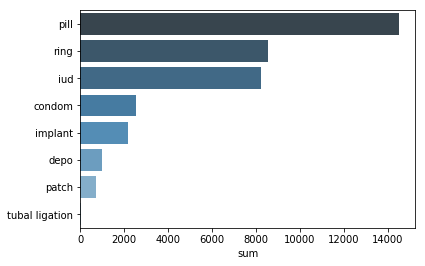

In [65]:
types_plot = sns.barplot(x = type_sum['sum'], y = type_sum.index, palette = "Blues_d")

In [8]:
#Subsetting dataframe based on the user's input (for now, IUD)

IUD = new_df[new_df['SENTENCE'].str.contains("iud")]
IUD = pd.DataFrame(IUD)
# IUD.to_csv('IUD_Data.csv')

#reset index for subsetted dataframe
IUD = IUD.reset_index(drop=True)

,ID,SENTENCE
0,8s6n5g,"i, myself, have a copper iud (either paragard ..."
1,8s87fp,looking for advice from anyway who has had an ...
2,8s87fp,i'm booking in for an iud insertion this week ...
3,8s8l0d,i'm going to be getting a kyleena iud in 3 weeks.
4,8s9hu2,i got the mirena iud last year in september.
5,8s9hu2,a couple days ago i started bleeding and havin...
6,8s9llg,my obgyn now no longer wants me having an iud ...
7,8sanno,"i have an iud, so i m not worried about being ..."
8,8sb4qj,my doctor suggested i try an iud since the hor...
9,8sb4qj,"from anyone who has had a hormonal iud, could ..."


In [10]:
pill = new_df[new_df['SENTENCE'].str.contains("pill")]
pill = pd.DataFrame(pill)
# pill.to_csv('pill_Data.csv')

#reset index for subsetted dataframe
pill = pill.reset_index(drop=True)

In [11]:
condom = new_df[new_df['SENTENCE'].str.contains("condom")]
condom = pd.DataFrame(condom)
# condom.to_csv('condom_Data.csv')

#reset index for subsetted dataframe
condom = condom.reset_index(drop=True)

In [12]:
patch = new_df[new_df['SENTENCE'].str.contains("patch")]
patch = pd.DataFrame(patch)
# patch.to_csv('patch_Data.csv')

#reset index for subsetted dataframe
patch = patch.reset_index(drop=True)

In [13]:
implant = new_df[new_df['SENTENCE'].str.contains("implant")]
implant = pd.DataFrame(implant)
# implant.to_csv('implant_Data.csv')

#reset index for subsetted dataframe
implant = implant.reset_index(drop=True)

In [14]:
ring = new_df[new_df['SENTENCE'].str.contains("ring")]
ring = pd.DataFrame(ring)
# ring.to_csv('ring_Data.csv')

#reset index for subsetted dataframe
ring = ring.reset_index(drop=True)

In [15]:
depo = new_df[new_df['SENTENCE'].str.contains("depo")]
depo = pd.DataFrame(depo)
# ring.to_csv('ring_Data.csv')

#reset index for subsetted dataframe
depo = depo.reset_index(drop=True)

In [16]:
tubes_tied = new_df[new_df['SENTENCE'].str.contains("tubes tied")]
tubes_tied = pd.DataFrame(tubes_tied)
# tubes_tied.to_csv('tubes_tied_Data.csv')

#reset index for subsetted dataframe
tubes_tied = tubes_tied.reset_index(drop=True)

In [17]:
tubal_ligation = new_df[new_df['SENTENCE'].str.contains("tubal ligation")]
tubal_ligation = pd.DataFrame(tubal_ligation)
# tubes_tied.to_csv('tubes_tied_Data.csv')

#reset index for subsetted dataframe
tubal_ligation = tubal_ligation.reset_index(drop=True)

In [18]:
tubes_tied.join(tubal_ligation)

ValueError: columns overlap but no suffix specified: Index(['ID', 'SENTENCE'], dtype='object')

In [ ]:
tubal_ligation.tail(10)

In [19]:
sentences = tubal_ligation.append([depo, ring, implant, pill, condom, patch, IUD])

In [24]:
sentences = sentences.sample(frac=1).reset_index(drop=True)

In [25]:
sentences.to_csv("Sentences to Rate.csv")

In [32]:
##Creating a function that 
#counts the occurence of each side effect in the text and
#populates the columns named by the side effect type

side_effects = ["pain", "cramp", "bleed", "spot", "irregular", "mood swing", "depressed", "weight gain", "weight loss",
                "headache", "ache", "acne", "nausea", "dizzy", "discomfort", "perforate", "tender", "discharge",
                "irritate", "infect", "allergic", "burn", "rash", "itch", "tire", "vomit"]
def counting_effects(dataFrame, text_field, side_effects):
    effects = np.zeros([dataFrame.shape[0],len(side_effects)])
    for i in range(dataFrame.shape[0]):
        entry = dataFrame[text_field][i]
        for j in range(len(side_effects)):
#             print(entry)
            this_effect = side_effects[j]
            if this_effect in entry:
#                 print(this_effect)
                effects[i,j] = 1
    return effects
    
IUD_counts = counting_effects(IUD, "SENTENCE", side_effects)
pill_counts = counting_effects(pill, "SENTENCE", side_effects)
condom_counts = counting_effects(condom, "SENTENCE", side_effects)
patch_counts = counting_effects(patch, "SENTENCE", side_effects)
ring_counts = counting_effects(ring, "SENTENCE", side_effects)
depo_counts = counting_effects(depo, "SENTENCE", side_effects)
implant_counts = counting_effects(implant, "SENTENCE", side_effects)
tubes_counts = counting_effects(tubal_ligation, "SENTENCE", side_effects)

##Creates a dataframe with the counts 
IUDcounts = pd.DataFrame(IUD_counts, columns = side_effects)
pillcounts = pd.DataFrame(pill_counts, columns = side_effects)
condomcounts = pd.DataFrame(condom_counts, columns = side_effects)
patchcounts = pd.DataFrame(patch_counts, columns = side_effects)
ringcounts = pd.DataFrame(ring_counts, columns = side_effects)
depocounts = pd.DataFrame(depo_counts, columns = side_effects)
implantcounts = pd.DataFrame(implant_counts, columns = side_effects)
tubescounts = pd.DataFrame(tubes_counts, columns = side_effects)

In [33]:
##Joining sentences with counts
IUD_total = IUD.join(IUDcounts)
pill_total = pill.join(pillcounts)
condom_total = condom.join(condomcounts)
patch_total = patch.join(patchcounts)
ring_total = ring.join(ringcounts)
depo_total = depo.join(depocounts)
implant_total = implant.join(implantcounts)
tubes_total = tubal_ligation.join(tubescounts)

So now we have each sentence with mention of a side effect.
**Next we need to analyze the sentiment of each sentence in the dataframe. A good package to start with would be NLTK sentiment analyzer. Stanford Core NLP analyzes the whole paragraph of text, by splitting individual sentences and analyzing each sentence by itself. Might be useful to conduct a tree parser to see how NLTK treats sentences?**

In [34]:
#SENTIMENT ANALYSIS ON IUD SENTENCES --

sia = SIA()
results_body = []
for entry in IUD_total["SENTENCE"]:
    body_score = sia.polarity_scores(entry)
    body_score['SENTENCE'] = entry
    results_body.append(body_score)
IUD_results = pd.DataFrame(results_body)

IUD_sentiments = pd.merge(IUD_total, IUD_results, on='SENTENCE')

In [35]:
#SENTIMENT ANALYSIS ON pill SENTENCES --

sia = SIA()
results_body = []
for entry in pill_total["SENTENCE"]:
    body_score = sia.polarity_scores(entry)
    body_score['SENTENCE'] = entry
    results_body.append(body_score)
pill_results = pd.DataFrame(results_body)

pill_sentiments = pd.merge(pill_total, pill_results, on='SENTENCE')

In [36]:
#SENTIMENT ANALYSIS ON patch SENTENCES --

sia = SIA()
results_body = []
for entry in patch_total["SENTENCE"]:
    body_score = sia.polarity_scores(entry)
    body_score['SENTENCE'] = entry
    results_body.append(body_score)
patch_results = pd.DataFrame(results_body)

patch_sentiments = pd.merge(patch_total, patch_results, on='SENTENCE')

In [37]:
#SENTIMENT ANALYSIS ON implant SENTENCES --

sia = SIA()
results_body = []
for entry in implant_total["SENTENCE"]:
    body_score = sia.polarity_scores(entry)
    body_score['SENTENCE'] = entry
    results_body.append(body_score)
implant_results = pd.DataFrame(results_body)

implant_sentiments = pd.merge(implant_total, implant_results, on='SENTENCE')

In [38]:
#SENTIMENT ANALYSIS ON ring SENTENCES --

sia = SIA()
results_body = []
for entry in ring_total["SENTENCE"]:
    body_score = sia.polarity_scores(entry)
    body_score['SENTENCE'] = entry
    results_body.append(body_score)
ring_results = pd.DataFrame(results_body)

ring_sentiments = pd.merge(ring_total, ring_results, on='SENTENCE')

In [39]:
#SENTIMENT ANALYSIS ON tubal ligation SENTENCES --

sia = SIA()
results_body = []
for entry in tubes_total["SENTENCE"]:
    body_score = sia.polarity_scores(entry)
    body_score['SENTENCE'] = entry
    results_body.append(body_score)
tubes_results = pd.DataFrame(results_body)

tubes_sentiments = pd.merge(tubes_total, tubes_results, on='SENTENCE')

In [40]:
#SENTIMENT ANALYSIS ON depo SENTENCES --

sia = SIA()
results_body = []
for entry in depo_total["SENTENCE"]:
    body_score = sia.polarity_scores(entry)
    body_score['SENTENCE'] = entry
    results_body.append(body_score)
depo_results = pd.DataFrame(results_body)

depo_sentiments = pd.merge(depo_total, depo_results, on='SENTENCE')

In [41]:
#SENTIMENT ANALYSIS ON condom SENTENCES --

sia = SIA()
results_body = []
for entry in condom_total["SENTENCE"]:
    body_score = sia.polarity_scores(entry)
    body_score['SENTENCE'] = entry
    results_body.append(body_score)
condom_results = pd.DataFrame(results_body)

condom_sentiments = pd.merge(condom_total, condom_results, on='SENTENCE')

In [28]:
condom_sentiments.head(10)

,ID,SENTENCE,pain,cramp,bleed,spot,irregular,mood swing,depress,weight gain,...,allerg,burn,rash,itch,tire,vomit,compound,neg,neu,pos
0,8s6sb4,its my first time having sex without a condom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,1.000,0.000
1,8s7d94,i want to stop because of some very bad side e...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.2484,0.214,0.607,0.179
2,8s88p4,so i had a scare and i m unprotected (condom b...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.8261,0.183,0.773,0.043
3,8s9sz7,"condom slipped and didn t notice, felt 2 puls...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,1.000,0.000
4,8scn8c,he has suggested condoms because he doesnt wan...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.6889,0.153,0.847,0.000
5,8scn8c,here are the options i have narrowed it down t...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0622,0.150,0.706,0.144
6,8rx01f,hello!i've been on and off the pill for about ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,1.000,0.000
7,8ry9g7,me and my boyfriend were having sex and the co...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.4215,0.113,0.887,0.000
8,8ry9g7,we switched condoms.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0000,0.000,1.000,0.000
9,8s1ly4,me and boyfriend use condoms.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,1.000,0.000


In [99]:
tubes_sentiments = tubes_sentiments.drop(['ID', 'SENTENCE'], 1)
tubes_sentiments.head(10)

,pain,cramp,bleed,spot,irregular,mood swing,depressed,weight gain,weight loss,headache,...,allergic,burn,rash,itch,tire,vomit,compound,neg,neu,pos
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.1232,0.080,0.920,0.000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,1.000,0.000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.2732,0.045,0.874,0.081
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.6052,0.165,0.835,0.000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.2942,0.083,0.767,0.150
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,1.000,0.000
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.4939,0.000,0.918,0.082
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,1.000,0.000
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.6682,0.000,0.711,0.289
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.4064,0.163,0.691,0.146


In [100]:
#Calculates the percent of the total occurence of side effects per side effect
total = sum(tubes_sentiments.sum())
by_effect = tubes_sentiments.sum()
percent = (by_effect/total)*100
# print(percent)

freq = pd.DataFrame(percent)
number = pd.DataFrame(by_effect)

In [101]:
###MULTIPLY ROW VALUE IN COLUMN BY COMPOUD

sentiments = pd.DataFrame()
for column in tubes_sentiments.columns:
    sentiments[column] = tubes_sentiments[column] * tubes_sentiments['compound']

sentiments = sentiments.drop(['compound', 'neg', 'neu', 'pos'], 1)

In [102]:
sum_row = {col: sentiments[col].sum() for col in sentiments}
sum_df = pd.DataFrame(sum_row, index=["Total"])

sums = sum_df.transpose()
sums.index.name = 'name'

In [103]:
###Merge sums of sentiments and number of occurrences by index name
final = sums.join(freq)
# final = final.join(freq)
final.columns = ["Tubes_Sentiment", "Tubes_Freq"]
final.reset_index(level=0, inplace=True)

In [104]:
tubes_sentiments = pd.DataFrame(final)

In [110]:
###Joining all eight sentiment dataframes together?
data_frames = [tubes_sentiments, IUD_sentiments, pill_sentiments, patch_sentiments,
              implant_sentiments, ring_sentiments, condom_sentiments, depo_sentiments]

sentiments_merged = functools.reduce(lambda  left,right: pd.merge(left,right,on=['name'],
                                            how='outer'), data_frames)

,name,Tubes_Sentiment,Tubes_Freq,IUD_Sentiment,IUD_Freq,Pill_Sentiment,Pill_Freq,Patch_Sentiment,Patch_Freq,Implant_Sentiment,Implant_Freq,Ring_Sentiment,Ring_Freq,Condom_Sentiment,Condom_Freq,Depo_Sentiment,Depo_Freq
16,nausea,0.0000,0.000000,-1.0593,0.091723,-16.1546,0.467594,-1.5495,1.197855,-0.7989,0.239917,-11.2268,0.369304,-1.2203,0.239917,-2.2699,0.309607
17,pain,0.8555,1.605765,-234.5015,5.714342,-125.5167,1.768258,-8.5070,1.524543,-34.8721,2.570537,-230.5848,4.581133,-13.2445,2.570537,-12.1213,2.244651
18,perforate,0.0000,0.000000,-0.3843,0.146757,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,-2.2964,0.070344,0.0000,0.000000,0.0000,0.000000
19,rash,0.0000,0.000000,-1.6165,0.036689,-1.5024,0.042997,-2.3797,0.544480,-0.7887,0.034274,-2.0214,0.061551,0.2191,0.034274,0.0000,0.000000
20,spot,0.0000,0.000000,-1.4579,1.935355,4.6053,2.246601,-1.1040,2.069022,-9.5239,2.844728,-0.3975,2.294963,-0.6305,2.844728,-0.9818,2.399455
21,tender,0.0000,0.000000,1.1208,0.018345,4.1255,0.161239,0.0000,0.000000,1.5487,0.068548,6.0314,0.202238,0.5719,0.068548,0.4588,0.077402
22,tire,0.0000,0.000000,-8.4622,0.476960,-16.5977,0.795447,-1.1510,0.435584,-5.4085,0.651203,-12.8353,0.764988,-2.8309,0.651203,-3.7933,0.851419
23,vomit,0.0000,0.000000,-1.0660,0.100895,-14.5638,0.306355,-0.3268,0.435584,-0.5283,0.034274,-1.1057,0.087930,-0.0145,0.034274,-1.4701,0.154804
24,weight gain,0.0000,0.000000,9.1997,0.440270,19.8281,0.446095,0.5781,0.544480,12.2185,0.993941,9.9327,0.457234,0.6631,0.993941,2.0150,1.470634
25,weight loss,0.0000,0.000000,-0.7229,0.018345,0.6544,0.037623,0.0000,0.000000,-1.7141,0.102821,1.2035,0.061551,0.8692,0.102821,-0.0644,0.077402


In [113]:
sentiments_merged.to_csv('all_side_effects.csv')

In [ ]:
##Labeling posts as "positive" or "negative"
##Decided to get rid of "neutral" posts by lumping them in with positives. Should I go ahead and drop them altogether?
IUD_sentiments['label'] = 0
IUD_sentiments.loc[IUD_sentiments['compound'] >= 0.0, 'label'] = 1
IUD_sentiments.loc[IUD_sentiments['compound'] < -0.0, 'label'] = -1

##Proportion of posts that are positive/negative:
# print(IUD_sentiments.label.value_counts(normalize=True) * 100)

In [ ]:
###CREATE SCATTERPLOT WITH QUADRANTS
p1=sns.regplot(data=final, x="Sentiment", y="Freq", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})

for line in range(0,final.shape[0]):
     p1.text(final.Sentiment[line]+0.2, final.Freq[line], final.name[line], horizontalalignment='left', size='medium', color='black')

In [ ]:
###USE GROUPBY FOR SENTI BY SIDE EFFECT = 1
###Maybe drop rows that have no side effects? Try with all rows first
# IUD_sentiments[IUD_sentiments[column]==1].groupby(column, as_index=False)['compound'].mean()

senti = {}
for column in IUD_sentiments.columns:
    output = IUD_sentiments[IUD_sentiments[column]==1].groupby(column, as_index = False)['compound'].mean()
    if not output.empty:
#         print(output)
        senti[column] = output['compound'][1]
#     print(output['compound'])
#     total_senti.append(senti)
#     senti[column] = IUD_sentiments[IUD_sentiments[column]==1].groupby(column, as_index=False)['compound'].mean()
#     IUD_sentiments.groupby('pain', as_index=False)['compound'].mean()
print(senti)

# print(output)
# pd.DataFrame(senti.items()) 

In [ ]:
##Tokenize words

body_tokenized = []

for entry in new["selftext"]:
    tokens = nltk.word_tokenize(entry)
    body_tokenized.append(tokens)
    
new["body_tokenized"] = body_tokenized
new.head(10)

In [ ]:
##Dropping stop words from tokenized list
stop_words = set(stopwords.words('english'))
keepwords = ['against', 'ain', "aren't", 'but', "couldn't", 'couldn', "didn't", 'doesn'
                 , "doesn't", 'don', "don't", 'hadn', "hadn't", 'hasn', "hasn't"
                 , 'haven', "haven't", 'isn', "isn't", 'll', 'mightn', "mightn't"
                 , 'mustn', "mustn't", 'needn', "needn't", 'no', "not", "nor", "only"
                 , "shan", "shan't", "shouldn't", "should've", "shouldn", "wasn", "wasn't"
                 , "weren", "weren't", "won't", "wouldn", "wouldn't"]

for keepword in keepwords:
    if keepword in stop_words:
        stop_words.remove(keepword)


body_new = []

for entry in new["body_tokenized"]:
    filtered_sentence = [w for w in entry if not w in stop_words]
    filtered_sentence = []
    for w in entry:
        if w not in stop_words:
            filtered_sentence.append(w)
    body_new.append(filtered_sentence)
    
new["body_new"] = body_new
new.tail(10)

In [ ]:
##tokenize and lemmatize each text body entry in dataframe

lemmatizer = WordNetLemmatizer()

body_lemmatized = []

for entry in new["body_new"]:
    templist = []
    for word in entry:
        lemma = lemmatizer.lemmatize(word)
        templist.append(lemma)
    body_lemmatized.append(templist)

new["body_lemmatized"] = body_lemmatized

In [ ]:
body_lemma = []
for entry in new["body_lemmatized"]:
    body_lemma.append(" ".join(entry))

new["body_clean"] = body_lemma

In [ ]:
new["body_clean"][2]

In [ ]:
#Split sentences in selftext & title and put in a dataframe?

body_sentences = []
comment_id = []
for counter in np.arange(IUD.shape[0]):
    sentences = sent_tokenize(IUD["selftext"][i])
    body_sentences.append(sentences)
    comment_id.append()

# print(body_sentences)

#Flattening list of lists into a single list
flatten = lambda l: [item for sublist in body_sentences for item in sublist]
flatten(body_sentences)